In [74]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import GTools as gt
import pandas as pd
import tracktor as tr
import os
import multiprocessing as mp

from scipy.spatial import distance
from itertools import combinations

In [63]:
def getBackground(Video, n):
    video = cv.VideoCapture(Video)
    # count the total frames in the video
    count = int(video.get(cv.CAP_PROP_FRAME_COUNT))
    # calculate the modulo
    modulo = count % n
    # select equally spaced frames across the video 
    frame_index = np.linspace(0, count - modulo, n+1).astype(np.int64)
    # set up lists to hold each color channel
    frames_b = []
    frames_g = []
    frames_r = []
    counter = 0
    while video.isOpened():
        ret, frame = video.read()
        if ret:
            if np.isin(counter, frame_index):
                # get the frame and put each color channel to the list
                frames_b.append(frame[:,:,0].astype(np.int64))
                frames_g.append(frame[:,:,1].astype(np.int64))
                frames_r.append(frame[:,:,2].astype(np.int64))
            counter += 1
        else: 
            break
    # stack all frames together and take the median
    stacked_b = np.stack(frames_b, axis = 2)
    median_b = np.abs(np.median(stacked_b, axis = 2))
    stacked_g = np.stack(frames_g, axis = 2)
    median_g = np.abs(np.median(stacked_g, axis = 2))
    stacked_r = np.stack(frames_r, axis = 2)
    median_r = np.abs(np.median(stacked_r, axis = 2))
    # merge median frame together to one frame
    background = cv.merge((median_b, median_g, median_r))
    video.release()
    background = cv.cvtColor(background.astype(np.uint8), cv.COLOR_BGR2RGB)
    return background

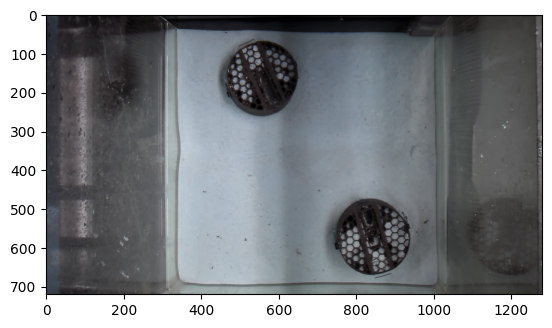

In [59]:
back= getBackground("Exp3/Video0028.MP4", 100)
plt.imshow(back)

In [60]:
cv.imwrite("bg.jpg", back)

True

In [ ]:
gt.VideoClip("Exp3/Video0028.MP4", "Clip.avi", 120000, 480000)

In [50]:
def MasterTracking(video_path, background_path = 0, threshold = 25):

    # Read in background images
    if background_path == 0:
        background = getBackground(video_path, 100)
    elif isinstance(background_path, str):
        background = cv.imread(background_path)

    # Collect user inputs
    shape, centers, radius, initBurrow = gt.InfoProcessor(background)
    n_inds = int(input("How many objects do you want to track? (Enter an integer):"))
    t_id = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    colours = [(0,0,255),(0,255,255),(255,0,255),(255,255,255),(255,255,0),(255,0,0),(0,255,0),(0,0,0)]
    meas_last = list(np.zeros((2,2)))
    meas_now = list(np.zeros((2,2)))
    df = []
    last = 0

    # Basic conversion and data collections of the background and croppedBackground
    size = (background.shape[1], background.shape[0])
    background = cv.cvtColor(background, cv.COLOR_RGB2GRAY)

    # Start video processing
    cap = cv.VideoCapture(video_path)
    ret, frame = cap.read()
    while ret:
        this = cap.get(1)
        print(this)
        frame = cv.resize(frame, size)
        frame = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
        delta = cv.absdiff(background, frame)
        delta = delta[shape[0]:shape[1], shape[2]:shape[3]]

        # Starts tracking
        thresh = gt.SingleImageProcessor(delta, threshold)
        final, contours, meas_last, meas_now = tr.detect_and_draw_contours(frame, thresh, meas_last, meas_now, 100, 10000)

        # Clear duplicated contours
        value = []
        for x,y in combinations(meas_now, 2):
            if distance.euclidean(x, y) < 8 and not (y in value):
                value.append(y)
        for i in value:
            meas_now.remove(i)

        while len(meas_now) < len(meas_last):
            if this == 1:
                meas_now.append(initBurrow)
                if len(meas_now) == len(meas_last):
                    break
            meas_now.append([0,0])
        row_ind, col_ind = tr.hungarian_algorithm(meas_last, meas_now)

        # reorder
        equal = np.array_equal(col_ind, list(range(len(col_ind))))
        if equal == False:
            current_ids = col_ind.copy()
            reordered = [i[0] for i in sorted(enumerate(current_ids), key=lambda x:x[1])]
            meas_now = [x for (y,x) in sorted(zip(reordered,meas_now))]
            
        if len(meas_now) > n_inds:
            meas_now = meas_now[0:n_inds]

        for i, meas in enumerate(meas_now):
            if meas == [0,0]:
                meas_now[i] = meas_last[i]

        for i in range(n_inds):
            df.append([this, meas_now[i][0]+shape[2], meas_now[i][1]+shape[0], t_id[i]])

        #cv.imshow("thresh", thresh)
        #if cv.waitKey(1) & 0xFF == ord('q'):
        #    break
        #Record the processed image


        if last >= this:
            break
        
        last = this
        ret, frame = cap.read()

    cv.destroyAllWindows()
    cap.release()

    df = pd.DataFrame(np.matrix(df), columns = ['frame','pos_x','pos_y', 'id'])
    return df



In [76]:
df = MasterTracking("Exp3/Video0029.MP4", "bg.jpg")

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
101.0
102.0
103.0
104.0
105.0
106.0
107.0
108.0
109.0
110.0
111.0
112.0
113.0
114.0
115.0
116.0
117.0
118.0
119.0
120.0
121.0
122.0
123.0
124.0
125.0
126.0
127.0
128.0
129.0
130.0
131.0
132.0
133.0
134.0
135.0
136.0
137.0
138.0
139.0
140.0
141.0
142.0
143.0
144.0
145.0
146.0
147.0
148.0
149.0
150.0
151.0
152.0
153.0
154.0
155.0
156.0
157.0
158.0
159.0
160.0
161.0
162.0
163.0
164.0
165.0
166.0
167.0
168.0
169.0
170.0
171.0
172.0
173.0
174.0
175.0
176.0
177.0
178.0
179.0
180.0
181.0
182.0
183.0
184.0
185.

In [69]:
df.to_csv("df.csv")

In [77]:
df

,frame,pos_x,pos_y,id
0,1.0,466,229,A
1,1.0,361,534,B
2,2.0,465,228,A
3,2.0,361,534,B
4,3.0,465,228,A
...,...,...,...,...
4047,2024.0,803,455,B
4048,2025.0,652,65,A
4049,2025.0,803,455,B
4050,2026.0,652,65,A


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
pd.options.mode.chained_assignment = None

def key_values(dataframe):
    df_storage = []


    for identity in dataframe["id"].unique():
        df_id = dataframe[dataframe["id"] == identity]

        dx = df_id['pos_x'] - df_id['pos_x'].shift(2)
        dy = df_id['pos_y'] - df_id['pos_y'].shift(2)
        df_id['speed'] = np.sqrt(dx**2 + dy**2)
        df_id = df_id.fillna(0)
        df_id['cum_dist'] = df_id['speed'].cumsum()
        df_id = df_id.sort_values(by=['frame'])

        important_vals = pd.DataFrame()
        important_vals["ID"] = [df_id["id"].iloc[0]]
        important_vals["Distance Traveled"] = [max(df_id["cum_dist"])]
        important_vals["Average Speed"] = [(df_id["speed"]).mean()]
        important_vals["Max Speed"] = [max(df_id["speed"])]
        important_vals["% Stationary"] = [(len(np.where(df_id["speed"] < 1)[0]) / len(df_id["speed"])) * 100]
        df_storage.append(important_vals) 
        
    combined_df = pd.concat(df_storage, axis = 0, ignore_index = True)
    return combined_df

def distances(dataframe, fps):
    df_storage = []
    
    # These lines below compute all of the different pairs of shrimp 
    diff_ids = dataframe["id"].unique()
    shrimp_combo = []
    for combo in combinations(diff_ids, 2):  # 2 for pairs, 3 for triplets, etc
        shrimp_combo.append(combo)
    
    # Loop through each pair of shrimp
    for pair in shrimp_combo:
        shrimpX = pair[0]
        shrimpY = pair[1]

        # This will subset our dataframe into one with just the two animals we care about
        dataframe2 = dataframe[(dataframe["id"] == shrimpX) | (dataframe["id"] == shrimpY)]

        for idx, ID in enumerate(np.unique(dataframe2['id'])):
                dataframe2['id'][dataframe2['id'] == ID] = idx
                #print(dataframe.shape)
        
        # Gets the distance between two shrimp for each frame
        distances = []
        for fr in np.unique(dataframe['frame']):
                tmp = dataframe2[dataframe2['frame'] == fr]
                x = tmp[tmp['id'] == 0]['pos_x'].values[0] - tmp[tmp['id'] == 1]['pos_x'].values[0]
                y = tmp[tmp['id'] == 0]['pos_y'].values[0] - tmp[tmp['id'] == 1]['pos_y'].values[0]
                distances.append(np.sqrt(x**2 + y**2))

        # Creates a timestamp column in seconds 
        timestamp = np.unique(dataframe2['frame'])/fps
        
        # Manipulates the timestamp column for easier-to-read results
        def convert_time(seconds):
            seconds = seconds % (24 * 3600)
            hour = seconds // 3600
            seconds %= 3600
            minutes = seconds // 60
            seconds %= 60     
            milliseconds = (seconds % 1) * 100
            milliseconds
            return "%d:%02d:%02d:%2d" % (hour, minutes, seconds, milliseconds)
        
        convert_time = np.vectorize(convert_time)
        timestamp = convert_time(timestamp)
        frames = np.unique(dataframe2['frame'])
        
        # Getting the list of the different pairs of shrimp
        pair_list = []
        for i in range(len(distances)):
                pair_list.append(pair)

        # Creates our dataframe of shrimp and their respective distance at individual moments
        dist_df = pd.DataFrame([pair_list, frames, timestamp, distances]).transpose()
        dist_df.columns = ["Pair", "Frame", "Timestamp", "Distance"]
        
        df_storage.append(dist_df)
    
    combined_df = pd.concat(df_storage, axis = 0, ignore_index = True)

    return combined_df

def timestamp(dataframe, cutoff):
    df_storage = []
    
    for pair in dataframe["Pair"].unique():
        pair_df = dataframe[dataframe["Pair"] == pair]
        
        # Creates a "Previous" column which defines where the shrimp were in the previous frame
        pair_df["Previous"] = (pair_df["Distance"].shift(1)).fillna(pair_df["Distance"])
        enter = []
        exit = []
        pair = pair_df["Pair"].iloc[0]

        # Case 2: The two shrimp are never within the distance threshold
        if (pair_df.loc[pair_df["Distance"] <= cutoff]).empty == True:
            enter.append(0)
            exit.append(0)
            label = [pair]

        # Case 2: The two shrimp are always within the distance threshold    
        elif (len(pair_df.loc[pair_df["Distance"] <= cutoff]) == len(pair_df)) == True:
            enter.append((pair_df["Timestamp"].iloc[0]))
            exit.append((pair_df["Timestamp"].iloc[-1]))
            label = [pair]

        # Case 3: The two shrimp move between being close and not close (most often) 
        else:
            if ((pair_df["Distance"].iloc[0]) <= cutoff) == True:
                enter.append((pair_df["Timestamp"].iloc[0]))
            for index, row in pair_df.iterrows():
                if ((row["Distance"] <= cutoff) & (row["Previous"] > cutoff)) == True:
                    start = row["Timestamp"]
                    enter.append(start)
                elif ((row["Distance"] > cutoff) & (row["Previous"] <= cutoff)) == True:
                    end = row["Timestamp"]
                    exit.append(end)
            if ((pair_df["Distance"].iloc[-1]) <= cutoff) == True:
                exit.append((pair_df["Timestamp"].iloc[-1]))
            label = [pair] * (len(enter))

        important_times = pd.DataFrame()
        important_times["Pair"] = label
        important_times["Start"] = enter
        important_times["End"] = exit
        df_storage.append(important_times)
    
    combined_df = pd.concat(df_storage, axis = 0, ignore_index = True)
    return combined_df

In [56]:
def MasterFunction(video_path, name, background_path = 0, threshold = 25, cutoff = 30):
    
    df = MasterTracking(video_path, background_path, threshold)
    kv = key_values(df)
    dist = distances(df, 30)
    ts = timestamp(dist, cutoff)
    
    

    kv_output = str(name) + "_keyvalues.csv"
    kv.to_csv(kv_output, sep = ",")

    dist_output = str(name) + "_distances.csv"
    dist.to_csv(dist_output, sep = ",")

    ts_output = str(name) + "_timestamps.csv"
    ts.to_csv(ts_output, sep = ",")